# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 7.00KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

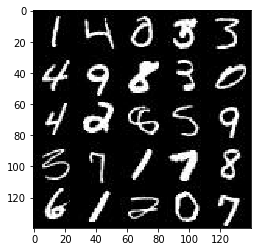

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

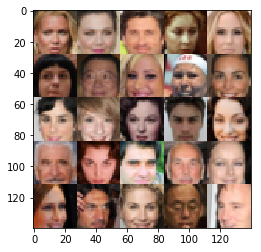

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        # conv1
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', activation=tf.nn.relu)
        
        # conv2
        x2 = tf.layers.conv2d(x1, 32, 5, strides=2, padding='same', activation=tf.nn.relu)
        
        # conv3
        x3 = tf.layers.conv2d(x2, 32, 5, strides=2, padding='same', activation=tf.nn.relu)
        
        # flatten
        flat = tf.reshape(x3, (-1, 4*4*32))
        
        # out
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # fc
        x1 = tf.layers.dense(z, 7*7*128)

        #  reshape
        x1 = tf.reshape(x1, (-1, 7, 7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)

        # conv1
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)

        # conv2
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)

        # out
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode)
    # 2 None None None None <bound method Dataset.get_batches...> (60000, 28, 28, 1) L
    
    steps = 0
    # def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real, inputs_z, inputs_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], 
                                                               z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, 
                                               inputs_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_learning_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={inputs_z: batch_z})
                    
                    print("Epoch {}/{}".format(epoch_i + 1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    # def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, 10, inputs_z, data_shape[3], data_image_mode)
                    
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2 128 100 0.0002 0.5 <bound method Dataset.get_batches of <helper.Dataset object at 0x7fe75a4a47b8>> (60000, 28, 28, 1) L
Epoch 1/2 Discriminator Loss: 1.2110 Generator Loss: 0.6925
Epoch 1/2 Discriminator Loss: 0.9618 Generator Loss: 0.7788
Epoch 1/2 Discriminator Loss: 0.9710 Generator Loss: 0.7428
Epoch 1/2 Discriminator Loss: 1.2285 Generator Loss: 0.6728
Epoch 1/2 Discriminator Loss: 1.4523 Generator Loss: 0.6387
Epoch 1/2 Discriminator Loss: 1.4167 Generator Loss: 0.6829
Epoch 1/2 Discriminator Loss: 1.3879 Generator Loss: 0.7171
Epoch 1/2 Discriminator Loss: 1.2635 Generator Loss: 0.7751
Epoch 1/2 Discriminator Loss: 1.2604 Generator Loss: 0.7779
Epoch 1/2 Discriminator Loss: 1.2091 Generator Loss: 0.7737


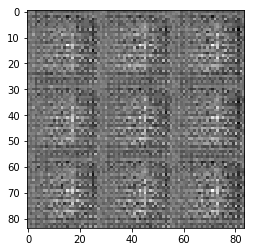

Epoch 1/2 Discriminator Loss: 1.1655 Generator Loss: 0.8517
Epoch 1/2 Discriminator Loss: 1.2510 Generator Loss: 0.7766
Epoch 1/2 Discriminator Loss: 1.2389 Generator Loss: 0.7784
Epoch 1/2 Discriminator Loss: 1.4196 Generator Loss: 0.7650
Epoch 1/2 Discriminator Loss: 1.3088 Generator Loss: 0.8704
Epoch 1/2 Discriminator Loss: 1.1514 Generator Loss: 0.7900
Epoch 1/2 Discriminator Loss: 1.1128 Generator Loss: 0.8750
Epoch 1/2 Discriminator Loss: 1.1725 Generator Loss: 1.2030
Epoch 1/2 Discriminator Loss: 1.6417 Generator Loss: 0.5490
Epoch 1/2 Discriminator Loss: 1.0223 Generator Loss: 0.7983


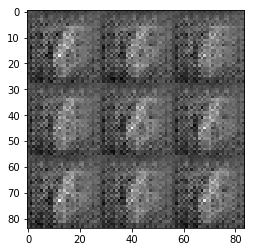

Epoch 1/2 Discriminator Loss: 1.4173 Generator Loss: 0.6036
Epoch 1/2 Discriminator Loss: 1.3479 Generator Loss: 0.7564
Epoch 1/2 Discriminator Loss: 1.1109 Generator Loss: 0.9207
Epoch 1/2 Discriminator Loss: 1.2061 Generator Loss: 0.7957
Epoch 1/2 Discriminator Loss: 1.3669 Generator Loss: 0.6848
Epoch 1/2 Discriminator Loss: 1.1250 Generator Loss: 0.8578
Epoch 1/2 Discriminator Loss: 1.3149 Generator Loss: 0.9303
Epoch 1/2 Discriminator Loss: 1.3507 Generator Loss: 0.6751
Epoch 1/2 Discriminator Loss: 1.0207 Generator Loss: 0.8303
Epoch 1/2 Discriminator Loss: 1.4616 Generator Loss: 0.8830


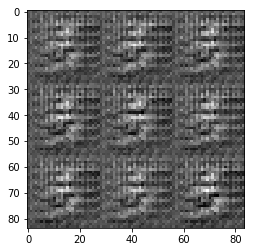

Epoch 1/2 Discriminator Loss: 1.2732 Generator Loss: 0.8334
Epoch 1/2 Discriminator Loss: 1.1440 Generator Loss: 0.8241
Epoch 1/2 Discriminator Loss: 1.0636 Generator Loss: 0.7643
Epoch 1/2 Discriminator Loss: 1.3625 Generator Loss: 0.4856
Epoch 1/2 Discriminator Loss: 1.0571 Generator Loss: 1.0583
Epoch 1/2 Discriminator Loss: 1.4296 Generator Loss: 0.6516
Epoch 1/2 Discriminator Loss: 1.1025 Generator Loss: 0.8622
Epoch 1/2 Discriminator Loss: 1.0362 Generator Loss: 0.7658
Epoch 1/2 Discriminator Loss: 1.4720 Generator Loss: 0.6321
Epoch 1/2 Discriminator Loss: 1.1366 Generator Loss: 0.7444


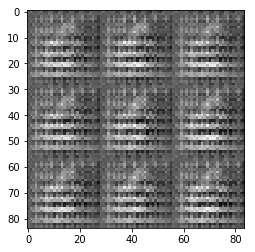

Epoch 1/2 Discriminator Loss: 1.2026 Generator Loss: 0.7158
Epoch 1/2 Discriminator Loss: 1.2629 Generator Loss: 0.7246
Epoch 1/2 Discriminator Loss: 0.9923 Generator Loss: 0.9000
Epoch 1/2 Discriminator Loss: 1.3942 Generator Loss: 0.6811
Epoch 1/2 Discriminator Loss: 1.1366 Generator Loss: 0.7635
Epoch 1/2 Discriminator Loss: 1.0041 Generator Loss: 0.9153
Epoch 2/2 Discriminator Loss: 1.0495 Generator Loss: 0.9662
Epoch 2/2 Discriminator Loss: 0.9237 Generator Loss: 0.9072
Epoch 2/2 Discriminator Loss: 1.2175 Generator Loss: 0.5605
Epoch 2/2 Discriminator Loss: 1.1703 Generator Loss: 0.8560


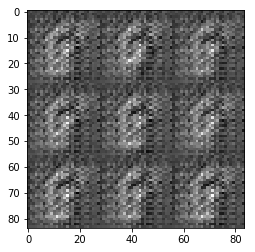

Epoch 2/2 Discriminator Loss: 1.4754 Generator Loss: 0.9637
Epoch 2/2 Discriminator Loss: 1.4205 Generator Loss: 0.5674
Epoch 2/2 Discriminator Loss: 1.2005 Generator Loss: 1.0480
Epoch 2/2 Discriminator Loss: 1.1191 Generator Loss: 0.8640
Epoch 2/2 Discriminator Loss: 1.3050 Generator Loss: 0.7209
Epoch 2/2 Discriminator Loss: 1.1098 Generator Loss: 0.9334
Epoch 2/2 Discriminator Loss: 1.1035 Generator Loss: 0.7732
Epoch 2/2 Discriminator Loss: 1.0977 Generator Loss: 0.8125
Epoch 2/2 Discriminator Loss: 1.1158 Generator Loss: 0.7870
Epoch 2/2 Discriminator Loss: 1.1715 Generator Loss: 0.5891


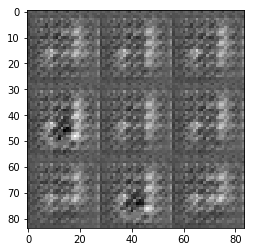

Epoch 2/2 Discriminator Loss: 0.9296 Generator Loss: 0.9191
Epoch 2/2 Discriminator Loss: 1.2736 Generator Loss: 0.5036
Epoch 2/2 Discriminator Loss: 1.4376 Generator Loss: 0.4187
Epoch 2/2 Discriminator Loss: 1.3308 Generator Loss: 0.4984
Epoch 2/2 Discriminator Loss: 1.0940 Generator Loss: 0.7319
Epoch 2/2 Discriminator Loss: 0.9992 Generator Loss: 0.9548
Epoch 2/2 Discriminator Loss: 0.9419 Generator Loss: 0.8752
Epoch 2/2 Discriminator Loss: 1.0778 Generator Loss: 0.9059
Epoch 2/2 Discriminator Loss: 1.1672 Generator Loss: 0.8870
Epoch 2/2 Discriminator Loss: 1.2259 Generator Loss: 0.6302


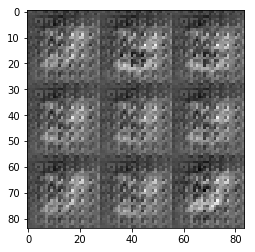

Epoch 2/2 Discriminator Loss: 0.9699 Generator Loss: 0.9669
Epoch 2/2 Discriminator Loss: 1.3416 Generator Loss: 0.4165
Epoch 2/2 Discriminator Loss: 0.9852 Generator Loss: 0.9774
Epoch 2/2 Discriminator Loss: 1.0835 Generator Loss: 0.9294
Epoch 2/2 Discriminator Loss: 1.1219 Generator Loss: 0.8037
Epoch 2/2 Discriminator Loss: 1.3276 Generator Loss: 0.7278
Epoch 2/2 Discriminator Loss: 1.1676 Generator Loss: 0.9897
Epoch 2/2 Discriminator Loss: 1.1842 Generator Loss: 0.8751
Epoch 2/2 Discriminator Loss: 1.1513 Generator Loss: 0.6625
Epoch 2/2 Discriminator Loss: 1.3098 Generator Loss: 0.5132


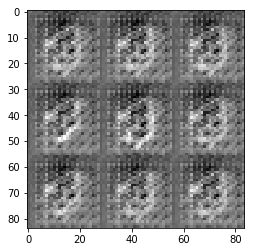

Epoch 2/2 Discriminator Loss: 1.2084 Generator Loss: 0.8277
Epoch 2/2 Discriminator Loss: 1.1806 Generator Loss: 0.7740
Epoch 2/2 Discriminator Loss: 1.1347 Generator Loss: 0.9546
Epoch 2/2 Discriminator Loss: 0.9954 Generator Loss: 1.0867
Epoch 2/2 Discriminator Loss: 1.1164 Generator Loss: 0.9037
Epoch 2/2 Discriminator Loss: 1.1627 Generator Loss: 0.8380
Epoch 2/2 Discriminator Loss: 1.1262 Generator Loss: 1.1353
Epoch 2/2 Discriminator Loss: 1.0808 Generator Loss: 1.0337
Epoch 2/2 Discriminator Loss: 0.8912 Generator Loss: 1.7200
Epoch 2/2 Discriminator Loss: 0.8987 Generator Loss: 1.8944


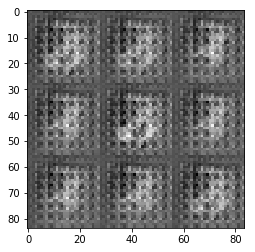

Epoch 2/2 Discriminator Loss: 0.9081 Generator Loss: 1.0432
Epoch 2/2 Discriminator Loss: 1.4322 Generator Loss: 0.5569
Epoch 2/2 Discriminator Loss: 1.1761 Generator Loss: 0.6505


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

1 128 100 0.0002 0.5 <bound method Dataset.get_batches of <helper.Dataset object at 0x7fe77f1c54a8>> (202599, 28, 28, 3) RGB
Epoch 1/1 Discriminator Loss: 1.3626 Generator Loss: 0.6417
Epoch 1/1 Discriminator Loss: 1.3207 Generator Loss: 0.6401
Epoch 1/1 Discriminator Loss: 1.2664 Generator Loss: 0.7532
Epoch 1/1 Discriminator Loss: 1.1761 Generator Loss: 0.8000
Epoch 1/1 Discriminator Loss: 1.1341 Generator Loss: 0.9077
Epoch 1/1 Discriminator Loss: 1.1605 Generator Loss: 0.8314
Epoch 1/1 Discriminator Loss: 1.0628 Generator Loss: 0.9998
Epoch 1/1 Discriminator Loss: 1.1509 Generator Loss: 0.7579
Epoch 1/1 Discriminator Loss: 1.2471 Generator Loss: 0.7270
Epoch 1/1 Discriminator Loss: 1.0424 Generator Loss: 0.8864


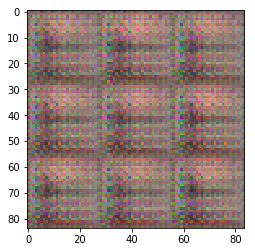

Epoch 1/1 Discriminator Loss: 1.0546 Generator Loss: 0.8990
Epoch 1/1 Discriminator Loss: 1.2406 Generator Loss: 0.8205
Epoch 1/1 Discriminator Loss: 1.5363 Generator Loss: 0.6379
Epoch 1/1 Discriminator Loss: 1.1680 Generator Loss: 0.9073
Epoch 1/1 Discriminator Loss: 1.1265 Generator Loss: 0.8125
Epoch 1/1 Discriminator Loss: 1.3492 Generator Loss: 0.6760
Epoch 1/1 Discriminator Loss: 1.2693 Generator Loss: 0.7428
Epoch 1/1 Discriminator Loss: 1.4422 Generator Loss: 0.6698
Epoch 1/1 Discriminator Loss: 1.2256 Generator Loss: 0.8642
Epoch 1/1 Discriminator Loss: 1.1736 Generator Loss: 0.8267


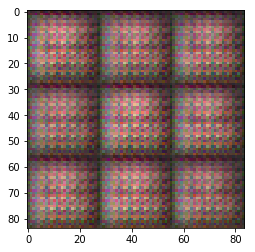

Epoch 1/1 Discriminator Loss: 1.4056 Generator Loss: 0.6874
Epoch 1/1 Discriminator Loss: 1.1793 Generator Loss: 0.8494
Epoch 1/1 Discriminator Loss: 1.1002 Generator Loss: 0.8666
Epoch 1/1 Discriminator Loss: 1.5146 Generator Loss: 0.6511
Epoch 1/1 Discriminator Loss: 1.1511 Generator Loss: 0.8062
Epoch 1/1 Discriminator Loss: 1.1315 Generator Loss: 0.7946
Epoch 1/1 Discriminator Loss: 1.0964 Generator Loss: 0.8628
Epoch 1/1 Discriminator Loss: 1.4381 Generator Loss: 0.7739
Epoch 1/1 Discriminator Loss: 1.1120 Generator Loss: 0.9470
Epoch 1/1 Discriminator Loss: 1.2033 Generator Loss: 0.7875


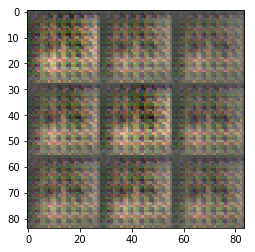

Epoch 1/1 Discriminator Loss: 0.9022 Generator Loss: 0.9693
Epoch 1/1 Discriminator Loss: 0.8970 Generator Loss: 1.0902
Epoch 1/1 Discriminator Loss: 1.4171 Generator Loss: 0.6354
Epoch 1/1 Discriminator Loss: 1.4254 Generator Loss: 0.7269
Epoch 1/1 Discriminator Loss: 1.1992 Generator Loss: 0.8648
Epoch 1/1 Discriminator Loss: 1.1058 Generator Loss: 0.8385
Epoch 1/1 Discriminator Loss: 1.2904 Generator Loss: 0.6985
Epoch 1/1 Discriminator Loss: 1.3353 Generator Loss: 0.7707
Epoch 1/1 Discriminator Loss: 1.4605 Generator Loss: 0.7017
Epoch 1/1 Discriminator Loss: 1.1918 Generator Loss: 0.8224


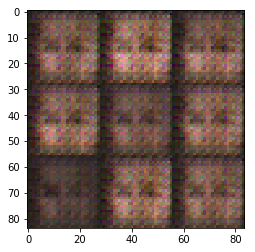

Epoch 1/1 Discriminator Loss: 1.2093 Generator Loss: 0.7472
Epoch 1/1 Discriminator Loss: 1.3758 Generator Loss: 0.6941
Epoch 1/1 Discriminator Loss: 1.4147 Generator Loss: 0.7038
Epoch 1/1 Discriminator Loss: 1.2750 Generator Loss: 0.8295
Epoch 1/1 Discriminator Loss: 1.1983 Generator Loss: 0.8234
Epoch 1/1 Discriminator Loss: 1.1339 Generator Loss: 0.8243
Epoch 1/1 Discriminator Loss: 1.2506 Generator Loss: 0.7567
Epoch 1/1 Discriminator Loss: 1.1857 Generator Loss: 0.7976
Epoch 1/1 Discriminator Loss: 1.1177 Generator Loss: 0.8018
Epoch 1/1 Discriminator Loss: 1.2402 Generator Loss: 0.8090


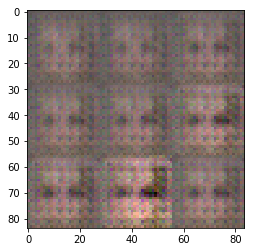

Epoch 1/1 Discriminator Loss: 1.2651 Generator Loss: 0.7751
Epoch 1/1 Discriminator Loss: 1.1173 Generator Loss: 0.8422
Epoch 1/1 Discriminator Loss: 1.2147 Generator Loss: 0.9576
Epoch 1/1 Discriminator Loss: 1.0903 Generator Loss: 0.8448
Epoch 1/1 Discriminator Loss: 1.1616 Generator Loss: 0.7925
Epoch 1/1 Discriminator Loss: 1.0188 Generator Loss: 0.9081
Epoch 1/1 Discriminator Loss: 1.1397 Generator Loss: 0.7950
Epoch 1/1 Discriminator Loss: 1.0036 Generator Loss: 1.2511
Epoch 1/1 Discriminator Loss: 1.3248 Generator Loss: 0.6300
Epoch 1/1 Discriminator Loss: 1.4311 Generator Loss: 0.5378


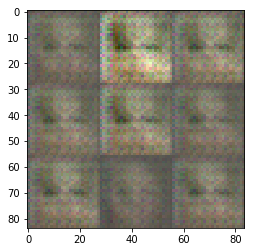

Epoch 1/1 Discriminator Loss: 1.3570 Generator Loss: 0.6648
Epoch 1/1 Discriminator Loss: 1.0707 Generator Loss: 0.8699
Epoch 1/1 Discriminator Loss: 1.1433 Generator Loss: 0.8710
Epoch 1/1 Discriminator Loss: 1.2557 Generator Loss: 0.7764
Epoch 1/1 Discriminator Loss: 1.0242 Generator Loss: 0.9448
Epoch 1/1 Discriminator Loss: 0.9809 Generator Loss: 1.1234
Epoch 1/1 Discriminator Loss: 1.2670 Generator Loss: 0.4840
Epoch 1/1 Discriminator Loss: 1.1684 Generator Loss: 0.7822
Epoch 1/1 Discriminator Loss: 1.1272 Generator Loss: 0.8195
Epoch 1/1 Discriminator Loss: 1.0017 Generator Loss: 0.8368


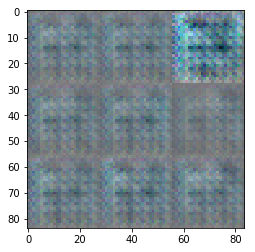

Epoch 1/1 Discriminator Loss: 1.1586 Generator Loss: 0.9408
Epoch 1/1 Discriminator Loss: 1.2906 Generator Loss: 0.9747
Epoch 1/1 Discriminator Loss: 1.5332 Generator Loss: 0.3718
Epoch 1/1 Discriminator Loss: 1.3862 Generator Loss: 0.5583
Epoch 1/1 Discriminator Loss: 1.1902 Generator Loss: 0.9215
Epoch 1/1 Discriminator Loss: 1.0004 Generator Loss: 1.2068
Epoch 1/1 Discriminator Loss: 1.0114 Generator Loss: 0.7434
Epoch 1/1 Discriminator Loss: 1.0166 Generator Loss: 1.7327
Epoch 1/1 Discriminator Loss: 1.1809 Generator Loss: 0.6267
Epoch 1/1 Discriminator Loss: 1.2507 Generator Loss: 0.9322


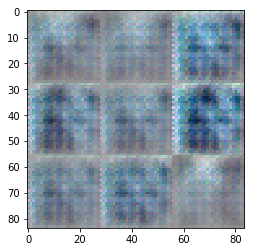

Epoch 1/1 Discriminator Loss: 1.1021 Generator Loss: 1.1063
Epoch 1/1 Discriminator Loss: 1.2403 Generator Loss: 0.8476
Epoch 1/1 Discriminator Loss: 1.3322 Generator Loss: 0.5296
Epoch 1/1 Discriminator Loss: 1.0027 Generator Loss: 0.8665
Epoch 1/1 Discriminator Loss: 0.8045 Generator Loss: 1.2161
Epoch 1/1 Discriminator Loss: 0.9033 Generator Loss: 0.8066
Epoch 1/1 Discriminator Loss: 1.0270 Generator Loss: 0.7192
Epoch 1/1 Discriminator Loss: 1.0809 Generator Loss: 1.6101
Epoch 1/1 Discriminator Loss: 1.2984 Generator Loss: 0.5236
Epoch 1/1 Discriminator Loss: 1.0929 Generator Loss: 0.9150


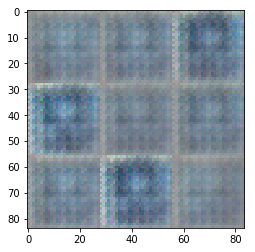

Epoch 1/1 Discriminator Loss: 0.9508 Generator Loss: 1.0967
Epoch 1/1 Discriminator Loss: 1.5343 Generator Loss: 0.3455
Epoch 1/1 Discriminator Loss: 0.9028 Generator Loss: 1.3701
Epoch 1/1 Discriminator Loss: 0.9840 Generator Loss: 1.1544
Epoch 1/1 Discriminator Loss: 1.0089 Generator Loss: 1.4073
Epoch 1/1 Discriminator Loss: 1.1267 Generator Loss: 0.6661
Epoch 1/1 Discriminator Loss: 1.0964 Generator Loss: 0.8969
Epoch 1/1 Discriminator Loss: 0.8731 Generator Loss: 1.8443
Epoch 1/1 Discriminator Loss: 0.9225 Generator Loss: 1.0172
Epoch 1/1 Discriminator Loss: 1.1259 Generator Loss: 0.7792


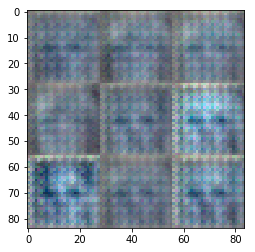

Epoch 1/1 Discriminator Loss: 0.9731 Generator Loss: 1.4118
Epoch 1/1 Discriminator Loss: 1.2895 Generator Loss: 1.4567
Epoch 1/1 Discriminator Loss: 0.9923 Generator Loss: 0.9964
Epoch 1/1 Discriminator Loss: 1.2719 Generator Loss: 0.5727
Epoch 1/1 Discriminator Loss: 1.3563 Generator Loss: 0.6361
Epoch 1/1 Discriminator Loss: 1.1272 Generator Loss: 0.7407
Epoch 1/1 Discriminator Loss: 1.1854 Generator Loss: 0.7635
Epoch 1/1 Discriminator Loss: 1.1960 Generator Loss: 1.1299
Epoch 1/1 Discriminator Loss: 1.0103 Generator Loss: 0.9310
Epoch 1/1 Discriminator Loss: 0.9771 Generator Loss: 1.1213


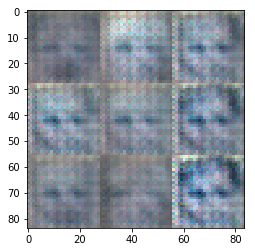

Epoch 1/1 Discriminator Loss: 1.1103 Generator Loss: 0.8370
Epoch 1/1 Discriminator Loss: 1.1297 Generator Loss: 0.9899
Epoch 1/1 Discriminator Loss: 1.0112 Generator Loss: 1.2652
Epoch 1/1 Discriminator Loss: 1.2074 Generator Loss: 1.2018
Epoch 1/1 Discriminator Loss: 1.1800 Generator Loss: 1.3362
Epoch 1/1 Discriminator Loss: 1.0654 Generator Loss: 0.7075
Epoch 1/1 Discriminator Loss: 0.7945 Generator Loss: 1.6058
Epoch 1/1 Discriminator Loss: 0.9268 Generator Loss: 0.9738
Epoch 1/1 Discriminator Loss: 1.0911 Generator Loss: 0.8047
Epoch 1/1 Discriminator Loss: 0.9630 Generator Loss: 1.4119


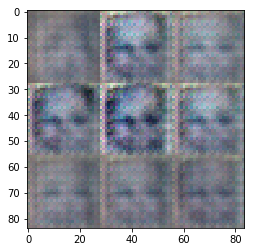

Epoch 1/1 Discriminator Loss: 1.1130 Generator Loss: 1.2544
Epoch 1/1 Discriminator Loss: 1.0163 Generator Loss: 1.7717
Epoch 1/1 Discriminator Loss: 1.1838 Generator Loss: 0.5628
Epoch 1/1 Discriminator Loss: 0.9853 Generator Loss: 1.1261
Epoch 1/1 Discriminator Loss: 1.2773 Generator Loss: 0.5893
Epoch 1/1 Discriminator Loss: 1.0653 Generator Loss: 0.8674
Epoch 1/1 Discriminator Loss: 1.2346 Generator Loss: 0.6194
Epoch 1/1 Discriminator Loss: 1.3443 Generator Loss: 0.5825
Epoch 1/1 Discriminator Loss: 1.4117 Generator Loss: 0.4763
Epoch 1/1 Discriminator Loss: 1.3829 Generator Loss: 0.4681


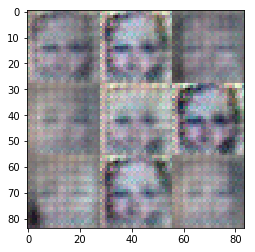

Epoch 1/1 Discriminator Loss: 1.2174 Generator Loss: 0.5625
Epoch 1/1 Discriminator Loss: 1.3300 Generator Loss: 0.5241
Epoch 1/1 Discriminator Loss: 1.3654 Generator Loss: 0.4746
Epoch 1/1 Discriminator Loss: 1.1313 Generator Loss: 0.5930
Epoch 1/1 Discriminator Loss: 1.0232 Generator Loss: 0.6684
Epoch 1/1 Discriminator Loss: 0.8551 Generator Loss: 1.1786
Epoch 1/1 Discriminator Loss: 0.7600 Generator Loss: 1.2525
Epoch 1/1 Discriminator Loss: 0.9406 Generator Loss: 0.9342
Epoch 1/1 Discriminator Loss: 0.9042 Generator Loss: 1.6370
Epoch 1/1 Discriminator Loss: 1.3741 Generator Loss: 0.4302


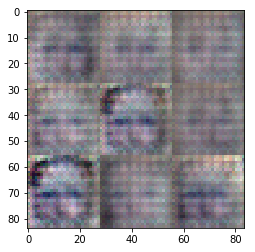

Epoch 1/1 Discriminator Loss: 0.9181 Generator Loss: 1.5203
Epoch 1/1 Discriminator Loss: 1.3038 Generator Loss: 0.5848
Epoch 1/1 Discriminator Loss: 1.0098 Generator Loss: 1.2730
Epoch 1/1 Discriminator Loss: 1.2770 Generator Loss: 1.0556
Epoch 1/1 Discriminator Loss: 1.0434 Generator Loss: 0.7896
Epoch 1/1 Discriminator Loss: 1.2221 Generator Loss: 0.6442
Epoch 1/1 Discriminator Loss: 1.0196 Generator Loss: 0.8843
Epoch 1/1 Discriminator Loss: 0.9471 Generator Loss: 1.5987
Epoch 1/1 Discriminator Loss: 1.1105 Generator Loss: 0.7086
Epoch 1/1 Discriminator Loss: 0.8514 Generator Loss: 1.5754


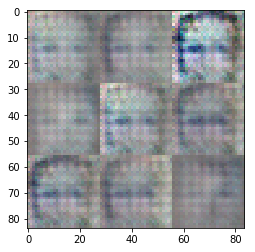

Epoch 1/1 Discriminator Loss: 1.2394 Generator Loss: 0.7121
Epoch 1/1 Discriminator Loss: 1.0937 Generator Loss: 0.8225
Epoch 1/1 Discriminator Loss: 1.1433 Generator Loss: 0.7081
Epoch 1/1 Discriminator Loss: 0.9887 Generator Loss: 1.5412
Epoch 1/1 Discriminator Loss: 0.9268 Generator Loss: 1.2165
Epoch 1/1 Discriminator Loss: 1.3015 Generator Loss: 1.5729
Epoch 1/1 Discriminator Loss: 0.9356 Generator Loss: 1.1184
Epoch 1/1 Discriminator Loss: 1.1221 Generator Loss: 0.7086


In [29]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.